In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pybaseball import statcast, cache
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import joblib
import math
from pybaseball import statcast
import scipy.stats as stats
from catboost import Pool
import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score
import sqlite3
cache.enable()

In [2]:
with sqlite3.connect("../../../Desktop/MLB Statcast.db") as conn:
    sc_23 = pd.read_sql_query("SELECT * FROM statcast_data_2023", conn)
    sc_22 = pd.read_sql_query("SELECT * FROM statcast_data_2022", conn)
    sc_21 = pd.read_sql_query("SELECT * FROM statcast_data_2021", conn)
    sc_20 = pd.read_sql_query("SELECT * FROM statcast_data_2020", conn)
conn.close()

In [3]:
spin_23 = pd.read_csv('../../spin_dir_2023.csv').drop(columns=['release_speed'])
spin_22 = pd.read_csv('../../spin_dir_2022.csv').drop(columns=['release_speed'])
spin_21 = pd.read_csv('../../spin_dir_2021.csv').drop(columns=['release_speed'])
spin_20 = pd.read_csv('../../spin_dir_2020.csv').drop(columns=['release_speed'])

In [4]:
sc_23 = pd.merge(sc_23, spin_23, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_22 = pd.merge(sc_22, spin_22, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_21 = pd.merge(sc_21, spin_21, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_20 = pd.merge(sc_20, spin_20, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')

In [5]:
total_sc = pd.concat([sc_23, sc_22, sc_21, sc_20])

In [6]:
[c for c in total_sc.columns]

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'fielder_2',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'pitcher.1',
 'fielder_2.1',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimat

In [7]:
total_sc['axis_dif'] = total_sc['diff_clock_hh'] * 10 + total_sc['diff_clock_mm']

In [8]:
features = ['release_speed', 'spin_axis', 'axis_dif', 'active_spin', 'pfx_x', 'pfx_z', 'release_extension', 'release_pos_x', 'release_pos_z']
total_sc = total_sc[total_sc[features].notnull().all(axis=1)]

In [9]:
total_sc.loc[total_sc['p_throws'] == 'L', 'pfx_x'] *= -1
total_sc.loc[total_sc['p_throws'] == 'L', 'release_pos_x'] *= -1
total_sc.loc[total_sc['p_throws'] == 'L', 'spin_axis'] = 360 - total_sc.loc[total_sc['p_throws'] == 'L', 'spin_axis']

In [10]:
total_sc = total_sc[~total_sc['pitch_name'].isin(['Pitch Out', 'Eephus', 'Knuckleball'])]

In [11]:
fastballs = ['4-Seam Fastball', 'Sinker']
offspeed = ['Split-Finger', 'Changeup', 'Forkball']
breaking = ['Curveball', 'Slider', 'Cutter', 'Knuckle Curve', 'Sweeper', 'Screwball', 'Slow Curve']

In [12]:
def get_pitch_data(total_sc, pitch_name, players):
    pitch_data = total_sc.loc[(total_sc['pitch_name'] == pitch_name) & (total_sc['player_name'].isin(players))]
    grouped_data = pitch_data.groupby('player_name').agg({
        'release_speed': 'median',
        'pfx_x': 'median',
        'pfx_z': 'median'
    }).reset_index()
    
    return grouped_data

all_players = total_sc['player_name'].unique()

fastball_data = get_pitch_data(total_sc, '4-Seam Fastball', all_players)
fastball_data = fastball_data.dropna(subset=['release_speed'])
fastball_velo_map = dict(zip(fastball_data['player_name'], fastball_data['release_speed']))
fastball_h_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_x']))
fastball_v_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_z']))

sinker_data = get_pitch_data(total_sc, 'Sinker', all_players)
sinker_data = sinker_data.dropna(subset=['release_speed'])
sinker_velo_map = dict(zip(sinker_data['player_name'], sinker_data['release_speed']))
sinker_h_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_x']))
sinker_v_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_z']))

cutter_data = get_pitch_data(total_sc, 'Cutter', all_players)
cutter_data = cutter_data.dropna(subset=['release_speed'])
cutter_velo_map = dict(zip(cutter_data['player_name'], cutter_data['release_speed']))
cutter_h_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_x']))
cutter_v_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_z']))

In [13]:
pitch_data = {
    '4-Seam Fastball': {
        'velo_map': fastball_velo_map,
        'h_mov_map': fastball_h_mov_map,
        'v_mov_map': fastball_v_mov_map
    },
    'Sinker': {
        'velo_map': sinker_velo_map,
        'h_mov_map': sinker_h_mov_map,
        'v_mov_map': sinker_v_mov_map
    },
    'Cutter': {
        'velo_map': cutter_velo_map,
        'h_mov_map': cutter_h_mov_map,
        'v_mov_map': cutter_v_mov_map
    }
}

def calculate_differences(row):
    player_name = row['player_name']
    for pitch_type in ['4-Seam Fastball', 'Sinker', 'Cutter']:
        if player_name in pitch_data[pitch_type]['velo_map']:
            velo_dif = row['release_speed'] - pitch_data[pitch_type]['velo_map'][player_name]
            h_mov_dif = row['pfx_x'] - pitch_data[pitch_type]['h_mov_map'][player_name]
            v_mov_dif = row['pfx_z'] - pitch_data[pitch_type]['v_mov_map'][player_name]
            return velo_dif, h_mov_dif, v_mov_dif

    return np.nan, np.nan, np.nan

total_sc['velo_dif'], total_sc['h_mov_dif'], total_sc['v_mov_dif'] = zip(*total_sc.apply(calculate_differences, axis=1))

In [14]:
total_sc = total_sc[(total_sc['velo_dif'] <= 0) | (total_sc['pitch_name'].isin(['Sinker', '4-Seam Fastball']))]

In [15]:
features_with_dif = features + ['h_mov_dif', 'v_mov_dif', 'velo_dif']

In [16]:
total_sc['description'] = np.where(total_sc['description'] == 'hit_into_play', total_sc['events'], total_sc['description'])
field_outs = ['force_out', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'field_out', 'double_play', 'sac_fly', 'field_error', 'sac_fly_double_play', 'triple_play']
total_sc['description'] = total_sc['description'].replace(field_outs, 'field_out')

In [17]:
total_sc.description.unique()

array(['swinging_strike', 'foul', 'called_strike', 'field_out', 'ball',
       'single', 'foul_tip', 'swinging_strike_blocked', 'blocked_ball',
       'double', 'hit_by_pitch', 'sac_bunt', 'home_run', 'triple',
       'foul_bunt', 'missed_bunt', 'bunt_foul_tip', 'catcher_interf',
       'unknown_strike', 'sac_bunt_double_play'], dtype=object)

In [18]:
total_sc['whiff'] = total_sc['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
total_sc['foul'] = total_sc['description'].isin(['foul', 'foul_tip'])
total_sc['in_play'] = total_sc['description'].isin(['single', 'double', 'triple', 'home_run', 'field_out'])
total_sc['swing'] = (total_sc['whiff'] | total_sc['foul'] | total_sc['in_play'])

total_sc['take'] = (~total_sc['swing'] & (total_sc['description'].isin(['hit_by_pitch', 'ball', 'called_strike', 'blocked_ball'])))
total_sc['hbp'] = total_sc['description'] == 'hit_by_pitch'
total_sc['ball'] = total_sc['description'].isin(['blocked_ball', 'ball'])
total_sc['strike'] = total_sc['description'] == 'called_strike'

total_sc['single'] = total_sc['description'] == 'single'
total_sc['double'] = total_sc['description'] == 'double'
total_sc['triple'] = total_sc['description'] == 'triple'
total_sc['home_run'] = total_sc['description'] == 'home_run'
total_sc['field_out'] = total_sc['description'] == 'field_out'

In [19]:
total_sc.loc[total_sc['swing'] & total_sc['foul'], 'type_swing'] = 'foul'
total_sc.loc[total_sc['swing'] & total_sc['in_play'], 'type_swing'] = 'in_play'
total_sc.loc[total_sc['swing'] & total_sc['whiff'], 'type_swing'] = 'whiff'

total_sc.loc[total_sc['take'] & total_sc['hbp'], 'type_take'] = 'hbp'
total_sc.loc[total_sc['take'] & total_sc['ball'], 'type_take'] = 'ball'
total_sc.loc[total_sc['take'] & total_sc['strike'], 'type_take'] = 'strike'

total_sc.loc[total_sc['in_play'] & total_sc['single'], 'type_in_play'] = 'single'
total_sc.loc[total_sc['in_play'] & total_sc['double'], 'type_in_play'] = 'double'
total_sc.loc[total_sc['in_play'] & total_sc['triple'], 'type_in_play'] = 'triple'
total_sc.loc[total_sc['in_play'] & total_sc['home_run'], 'type_in_play'] = 'home_run'
total_sc.loc[total_sc['in_play'] & total_sc['field_out'], 'type_in_play'] = 'field_out'

In [20]:
total_sc = total_sc.dropna(subset=['swing', 'take'])
total_sc = total_sc[total_sc['swing'] != total_sc['take']]

In [21]:
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp, fmin, tpe

def objective(space, X_train, X_test, y_train, y_test):
    model = XGBClassifier(
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        n_estimators=int(space['n_estimators']))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

le_swing = LabelEncoder()

swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(fastballs)]
swing_X = swing_df[features]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())

space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'seed': 12
}

best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print("Best parameters:", best_params)

swing_model = XGBClassifier(**best_params)
swing_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [13:19<00:00, 79.99s/trial, best loss: -0.4734903091462438]
Best parameters: {'max_depth': 18, 'gamma': 2.3150700518584255, 'reg_alpha': 107, 'reg_lambda': 0.9072444924349607, 'colsample_bytree': 0.9574987671576729, 'min_child_weight': 7, 'n_estimators': 191}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9574987671576729, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.3150700518584255, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=18, max_leaves=0,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=191, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [22]:
swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(breaking)]
swing_X = swing_df[features_with_dif]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())

best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

swing_bb_model = XGBClassifier(**best_params)
swing_bb_model.fit(X_train, y_train)

100%|██████████████████████████████████████████████| 10/10 [10:50<00:00, 65.08s/trial, best loss: -0.39158890850356065]
{'max_depth': 12, 'gamma': 1.9441462294843186, 'reg_alpha': 49, 'reg_lambda': 0.41358326857597183, 'colsample_bytree': 0.9360360225648818, 'min_child_weight': 9, 'n_estimators': 72}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9360360225648818, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.9441462294843186, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=72, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [23]:
swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(offspeed)]
swing_X = swing_df[features_with_dif]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

swing_offs_model = XGBClassifier(**best_params)
swing_offs_model.fit(X_train, y_train)

100%|██████████████████████████████████████████████| 10/10 [02:54<00:00, 17.44s/trial, best loss: -0.39741341516878564]
{'max_depth': 9, 'gamma': 1.1513259974006491, 'reg_alpha': 57, 'reg_lambda': 0.13142843113175728, 'colsample_bytree': 0.8407878600885292, 'min_child_weight': 4, 'n_estimators': 100}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8407878600885292, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.1513259974006491, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [24]:
le_take = LabelEncoder()

take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(fastballs)]
take_X = take_total_sc[features]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_model = XGBClassifier(**best_params)
take_model.fit(X_train, y_train)

100%|████████████████████████████████████████████████| 10/10 [13:25<00:00, 80.55s/trial, best loss: -0.641704284469787]
{'max_depth': 5, 'gamma': 5.510333976750391, 'reg_alpha': 156, 'reg_lambda': 0.1023559311025436, 'colsample_bytree': 0.5489717515956911, 'min_child_weight': 1, 'n_estimators': 121}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5489717515956911, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.510333976750391, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=121, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [25]:
take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(breaking)]
take_X = take_total_sc[features_with_dif]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_bb_model = XGBClassifier(**best_params)
take_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [10:25<00:00, 62.52s/trial, best loss: -0.6933683793312055]
{'max_depth': 9, 'gamma': 1.74994061703436, 'reg_alpha': 109, 'reg_lambda': 0.8471884245757022, 'colsample_bytree': 0.7654950112406164, 'min_child_weight': 0, 'n_estimators': 129}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7654950112406164, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.74994061703436, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=129, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [26]:
take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(offspeed)]
take_X = take_total_sc[features_with_dif]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_offs_model = XGBClassifier(**best_params)
take_offs_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [02:21<00:00, 14.17s/trial, best loss: -0.8020473365064876]
{'max_depth': 13, 'gamma': 3.6637617143951218, 'reg_alpha': 148, 'reg_lambda': 0.31661682360259413, 'colsample_bytree': 0.7352808318056439, 'min_child_weight': 3, 'n_estimators': 186}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7352808318056439, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.6637617143951218, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=13, max_leaves=0,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=186, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [27]:
le_woba = LabelEncoder()

woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(fastballs)]
woba_X = woba_total_sc[features]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_model = XGBClassifier(**best_params)
woba_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [05:58<00:00, 35.85s/trial, best loss: -0.6657740585774059]
{'max_depth': 4, 'gamma': 6.651704695905166, 'reg_alpha': 123, 'reg_lambda': 0.16323530586921697, 'colsample_bytree': 0.8143968371441002, 'min_child_weight': 5, 'n_estimators': 118}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8143968371441002, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6.651704695905166, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=118, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [28]:
woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(breaking)]
woba_X = woba_total_sc[features_with_dif]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_bb_model = XGBClassifier(**best_params)
woba_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [03:27<00:00, 20.71s/trial, best loss: -0.6831662562003538]
{'max_depth': 8, 'gamma': 1.8721487397400995, 'reg_alpha': 140, 'reg_lambda': 0.1259351360419776, 'colsample_bytree': 0.982178146346101, 'min_child_weight': 9, 'n_estimators': 55}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.982178146346101, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.8721487397400995, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [29]:
woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(offspeed)]
woba_X = woba_total_sc[features_with_dif]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_offs_model = XGBClassifier(**best_params)
woba_offs_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [01:34<00:00,  9.43s/trial, best loss: -0.6969193722494396]
{'max_depth': 15, 'gamma': 4.6757117163700315, 'reg_alpha': 93, 'reg_lambda': 0.5811385004467391, 'colsample_bytree': 0.9564601845063866, 'min_child_weight': 7, 'n_estimators': 196}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9564601845063866, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.6757117163700315, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=196, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [30]:
def will_swing_objective(trial, will_swing_X, will_swing_y):
    X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())
    
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", .05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
    }

    model = CatBoostClassifier(**params, silent=True, thread_count=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (swing)
    logloss = log_loss(y_test, y_pred)
    return logloss

will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(fastballs)]
will_swing_X = will_swing_total_sc[features]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=6)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_model = CatBoostClassifier(**best_params, silent=True)
will_swing_model.fit(X_train, y_train)

[I 2023-12-02 20:53:29,311] A new study created in memory with name: no-name-14f107fd-1a48-49fb-aea0-1ba55d9f83f9
[I 2023-12-02 20:56:17,699] Trial 0 finished with value: 0.6879915499015363 and parameters: {'iterations': 1853, 'learning_rate': 0.056410291982467095, 'depth': 4, 'colsample_bylevel': 0.58594060658573, 'min_data_in_leaf': 92}. Best is trial 0 with value: 0.6879915499015363.
[I 2023-12-02 20:57:57,317] Trial 1 finished with value: 0.6897724741088609 and parameters: {'iterations': 1774, 'learning_rate': 0.010808081001507538, 'depth': 8, 'colsample_bylevel': 0.05430285847164037, 'min_data_in_leaf': 36}. Best is trial 0 with value: 0.6879915499015363.
[I 2023-12-02 21:01:12,360] Trial 2 finished with value: 0.6871723736225465 and parameters: {'iterations': 1358, 'learning_rate': 0.04172210780135584, 'depth': 8, 'colsample_bylevel': 0.8870543591190839, 'min_data_in_leaf': 57}. Best is trial 2 with value: 0.6871723736225465.
[I 2023-12-02 21:02:41,477] Trial 3 finished with valu

Best hyperparameters: {'iterations': 1539, 'learning_rate': 0.03884394478136419, 'depth': 10, 'colsample_bylevel': 0.7774057191225736, 'min_data_in_leaf': 65}
Best logloss: 0.6867323899037618


In [31]:
will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(breaking)]
will_swing_X = will_swing_total_sc[features_with_dif]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=6)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_bb_model = CatBoostClassifier(**best_params, silent=True)
will_swing_bb_model.fit(X_train, y_train)

[I 2023-12-02 21:13:13,184] A new study created in memory with name: no-name-78c181a4-d0d2-407f-b8e8-e8819e323f80
[I 2023-12-02 21:14:40,913] Trial 0 finished with value: 0.6865150637248605 and parameters: {'iterations': 1786, 'learning_rate': 0.003116450722082323, 'depth': 1, 'colsample_bylevel': 0.900095292639406, 'min_data_in_leaf': 29}. Best is trial 0 with value: 0.6865150637248605.
[I 2023-12-02 21:16:16,558] Trial 1 finished with value: 0.6855093058960117 and parameters: {'iterations': 1837, 'learning_rate': 0.055416699303152676, 'depth': 1, 'colsample_bylevel': 0.8723876448255167, 'min_data_in_leaf': 51}. Best is trial 1 with value: 0.6855093058960117.
[I 2023-12-02 21:17:22,794] Trial 2 finished with value: 0.6855679485625324 and parameters: {'iterations': 1002, 'learning_rate': 0.008416753628597385, 'depth': 6, 'colsample_bylevel': 0.11150983391923347, 'min_data_in_leaf': 87}. Best is trial 1 with value: 0.6855093058960117.
[I 2023-12-02 21:18:32,348] Trial 3 finished with va

Best hyperparameters: {'iterations': 1476, 'learning_rate': 0.09482335789559689, 'depth': 9, 'colsample_bylevel': 0.3650762067838175, 'min_data_in_leaf': 9}
Best logloss: 0.6826931803375904


In [32]:
will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(offspeed)]
will_swing_X = will_swing_total_sc[features_with_dif]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=6)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_offs_model = CatBoostClassifier(**best_params, silent=True)
will_swing_offs_model.fit(X_train, y_train)

[I 2023-12-02 21:25:59,635] A new study created in memory with name: no-name-c79525b1-cfc5-480d-8590-81be71bf15f3
[I 2023-12-02 21:26:25,308] Trial 0 finished with value: 0.6905137760475923 and parameters: {'iterations': 1282, 'learning_rate': 0.015718107427136124, 'depth': 2, 'colsample_bylevel': 0.32802827835374876, 'min_data_in_leaf': 23}. Best is trial 0 with value: 0.6905137760475923.
[I 2023-12-02 21:27:12,462] Trial 1 finished with value: 0.68947147745487 and parameters: {'iterations': 1100, 'learning_rate': 0.07770754828115405, 'depth': 7, 'colsample_bylevel': 0.8273295768820352, 'min_data_in_leaf': 90}. Best is trial 1 with value: 0.68947147745487.
[I 2023-12-02 21:28:00,409] Trial 2 finished with value: 0.6883699468844716 and parameters: {'iterations': 1220, 'learning_rate': 0.01561979647411376, 'depth': 6, 'colsample_bylevel': 0.9818039945089807, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.6883699468844716.
[I 2023-12-02 21:28:39,076] Trial 3 finished with value: 

Best hyperparameters: {'iterations': 1220, 'learning_rate': 0.01561979647411376, 'depth': 6, 'colsample_bylevel': 0.9818039945089807, 'min_data_in_leaf': 10}
Best logloss: 0.6883699468844716


In [122]:
with sqlite3.connect("../../../Desktop/MLB Statcast.db") as conn:
    sc_23 = pd.read_sql_query("SELECT * FROM statcast_data_2023", conn)
conn.close()
spin_23 = pd.read_csv('../../spin_dir_2023.csv').drop(columns=['release_speed'])
sc_23 = pd.merge(sc_23, spin_23, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')

In [123]:
sc_23.loc[sc_23['p_throws'] == 'L', 'pfx_x'] *= -1
sc_23.loc[sc_23['p_throws'] == 'L', 'release_pos_x'] *= -1
sc_23.loc[sc_23['p_throws'] == 'L', 'spin_axis'] = 360 - sc_23.loc[sc_23['p_throws'] == 'L', 'spin_axis']

In [124]:
sc_23['axis_dif'] = sc_23['diff_clock_hh'] * 10 + sc_23['diff_clock_mm']

In [125]:
sc_23 = sc_23[sc_23[features].notnull().all(axis=1)]

In [126]:
all_players = sc_23['player_name'].unique()

fastball_data = get_pitch_data(sc_23, '4-Seam Fastball', all_players)
fastball_data = fastball_data.dropna(subset=['release_speed'])
fastball_velo_map = dict(zip(fastball_data['player_name'], fastball_data['release_speed']))
fastball_h_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_x']))
fastball_v_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_z']))

sinker_data = get_pitch_data(sc_23, 'Sinker', all_players)
sinker_data = sinker_data.dropna(subset=['release_speed'])
sinker_velo_map = dict(zip(sinker_data['player_name'], sinker_data['release_speed']))
sinker_h_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_x']))
sinker_v_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_z']))

cutter_data = get_pitch_data(sc_23, 'Cutter', all_players)
cutter_data = cutter_data.dropna(subset=['release_speed'])
cutter_velo_map = dict(zip(cutter_data['player_name'], cutter_data['release_speed']))
cutter_h_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_x']))
cutter_v_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_z']))

In [127]:
pitch_data = {
    '4-Seam Fastball': {
        'velo_map': fastball_velo_map,
        'h_mov_map': fastball_h_mov_map,
        'v_mov_map': fastball_v_mov_map
    },
    'Sinker': {
        'velo_map': sinker_velo_map,
        'h_mov_map': sinker_h_mov_map,
        'v_mov_map': sinker_v_mov_map
    },
    'Cutter': {
        'velo_map': cutter_velo_map,
        'h_mov_map': cutter_h_mov_map,
        'v_mov_map': cutter_v_mov_map
    }
}

sc_23['velo_dif'], sc_23['h_mov_dif'], sc_23['v_mov_dif'] = zip(*sc_23.apply(calculate_differences, axis=1))

In [128]:
fastball_df = sc_23[sc_23['pitch_name'].isin(fastballs)]
bb_df = sc_23[sc_23['pitch_name'].isin(breaking)]
offs_df = sc_23[sc_23['pitch_name'].isin(offspeed)]

In [129]:
values = {
    'home_run': 1.374328827219,
    'triple': 1.05755624961515,
    'double': 0.766083123898271,
    'single': 0.467292970729251,
    'ball': 0.0636883289483747,
    'hit_by_pitch': 0.0636883289483747,
    'blocked_ball': 0.0636883289483747,
    'foul': -0.0380502742575014,
    'foul_tip': -0.0380502742575014,
    'bunt_foul': -0.0380502742575014,
    'bunt_foul_tip': -0.0380502742575014,
    'called_strike': -0.065092516089806,
    'swinging_strike': -0.118124935770601,
    'swinging_strike_blocked': -0.118124935770601,
    'force_out': -0.1955687665555,
    'grounded_into_double_play': -0.1955687665555,
    'fielders_choice_out': -0.1955687665555,
    'fielders_choice': -0.1955687665555,
    'field_out': -0.1955687665555,
    'double_play': -0.1955687665555,
    'sac_fly': -0.236889645519856,
    'field_error': -0.236889645519856,
    'catcher_interf': -0.789788814378052,
    'sac_fly_double_play': -0.789788814378052,
    'triple_play': -0.789788814378052
}

In [130]:
swing_probs = swing_model.predict_proba(fastball_df[features])
take_probs = take_model.predict_proba(fastball_df[features])
ws_probs = will_swing_model.predict_proba(fastball_df[features])
woba_probs = woba_model.predict_proba(fastball_df[features])

fastball_df['whiff_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('whiff')]
fastball_df['in_play_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('in_play')]
fastball_df['foul_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('foul')]

fastball_df['strike_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('strike')]
fastball_df['ball_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('ball')]
fastball_df['hbp_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('hbp')]

fastball_df['single_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('single')]
fastball_df['double_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('double')]
fastball_df['triple_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('triple')]
fastball_df['hr_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('home_run')]
fastball_df['fo_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('field_out')]
fastball_df['xwOBAcon'] = values['single'] * fastball_df['single_prob'] + values['double'] * fastball_df['double_prob'] + values['triple'] * fastball_df['triple_prob'] + values['home_run'] * fastball_df['hr_prob'] + values['field_out'] * fastball_df['fo_prob']

fastball_df['swing_prob'] = ws_probs[:, list(will_swing_model.classes_).index('True')]
fastball_df['take_prob'] = 1 - fastball_df['swing_prob'] 

fastball_df['val_swing'] = values['swinging_strike'] * fastball_df['whiff_prob'] + values['foul'] * fastball_df['foul_prob']
+ fastball_df['xwOBAcon'] * fastball_df['in_play_prob']
fastball_df['val_take'] = values['called_strike'] * fastball_df['strike_prob'] + values['ball'] * fastball_df['ball_prob'] + values['hit_by_pitch'] * fastball_df['hbp_prob']
fastball_df['xRV'] = fastball_df['val_swing'] * fastball_df['swing_prob'] + fastball_df['val_take'] * fastball_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\3806814061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['whiff_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\3806814061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['in_play_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_1204

In [131]:
swing_bb_probs = swing_bb_model.predict_proba(bb_df[features_with_dif])
take_bb_probs = take_bb_model.predict_proba(bb_df[features_with_dif])
ws_bb_probs = will_swing_bb_model.predict_proba(bb_df[features_with_dif])
woba_bb_probs = woba_bb_model.predict_proba(bb_df[features_with_dif])

bb_df['whiff_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('whiff')]
bb_df['in_play_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('in_play')]
bb_df['foul_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('foul')]

bb_df['strike_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('strike')]
bb_df['ball_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('ball')]
bb_df['hbp_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('hbp')]

bb_df['single_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('single')]
bb_df['double_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('double')]
bb_df['triple_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('triple')]
bb_df['hr_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('home_run')]
bb_df['fo_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('field_out')]
bb_df['xwOBAcon'] = values['single'] * bb_df['single_prob'] + values['double'] * bb_df['double_prob'] + values['triple'] * bb_df['triple_prob'] + values['home_run'] * bb_df['hr_prob'] + values['field_out'] * bb_df['fo_prob']

bb_df['swing_prob'] = ws_bb_probs[:, list(will_swing_bb_model.classes_).index('True')]
bb_df['take_prob'] = 1 - bb_df['swing_prob'] 

bb_df['val_swing'] = values['swinging_strike'] * bb_df['whiff_prob'] + values['foul'] * bb_df['foul_prob']
+ bb_df['xwOBAcon'] * bb_df['in_play_prob']
bb_df['val_take'] = values['called_strike'] * bb_df['strike_prob'] + values['ball'] * bb_df['ball_prob'] + values['hit_by_pitch'] * bb_df['hbp_prob']
bb_df['xRV'] = bb_df['val_swing'] * bb_df['swing_prob'] + bb_df['val_take'] * bb_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\1959749140.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['whiff_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\1959749140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['in_play_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_1204

In [132]:
swing_offs_probs = swing_offs_model.predict_proba(offs_df[features_with_dif])
take_offs_probs = take_offs_model.predict_proba(offs_df[features_with_dif])
ws_offs_probs = will_swing_offs_model.predict_proba(offs_df[features_with_dif])
woba_offs_probs = woba_offs_model.predict_proba(offs_df[features_with_dif])

offs_df['whiff_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('whiff')]
offs_df['in_play_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('in_play')]
offs_df['foul_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('foul')]

offs_df['strike_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('strike')]
offs_df['ball_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('ball')]
offs_df['hbp_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('hbp')]

offs_df['single_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('single')]
offs_df['double_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('double')]
offs_df['triple_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('triple')]
offs_df['hr_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('home_run')]
offs_df['fo_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('field_out')]
offs_df['xwOBAcon'] = values['single'] * offs_df['single_prob'] + values['double'] * offs_df['double_prob'] + values['triple'] * offs_df['triple_prob'] + values['home_run'] * offs_df['hr_prob'] + values['field_out'] * offs_df['fo_prob']

offs_df['swing_prob'] = ws_offs_probs[:, list(will_swing_offs_model.classes_).index('True')]
offs_df['take_prob'] = 1 - offs_df['swing_prob'] 

offs_df['val_swing'] = values['swinging_strike'] * offs_df['whiff_prob'] + values['foul'] * offs_df['foul_prob']
+ offs_df['xwOBAcon'] * offs_df['in_play_prob']
offs_df['val_take'] = values['called_strike'] * offs_df['strike_prob'] + values['ball'] * offs_df['ball_prob'] + values['hit_by_pitch'] * offs_df['hbp_prob']
offs_df['xRV'] = offs_df['val_swing'] * offs_df['swing_prob'] + offs_df['val_take'] * offs_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\3390110069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offs_df['whiff_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\3390110069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offs_df['in_play_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ip

In [133]:
total_df = pd.concat([fastball_df, bb_df, offs_df])

In [265]:
def calculate_stuff_plus(pitch_sc, min_num_pitches=100):
    agg_stuff_plus = pitch_sc.groupby(['player_name', 'pitch_name']).agg(
        mean_xrv=('xRV', 'mean'),
        mean_rv=('delta_run_exp', 'mean'),
        num_pitches=('player_name', 'count'),
        velo=('release_speed', 'mean'),
        spin_rate=('release_spin_rate', 'mean'),
        vert_break=('pfx_z', 'mean'),
        horz_break=('pfx_x', 'mean')
    ).reset_index()
    
    agg_stuff_plus['xrv_100'] = agg_stuff_plus['mean_xrv'] * 100
    agg_stuff_plus['xrv_100_adj'] = abs(agg_stuff_plus['xrv_100'] - agg_stuff_plus['xrv_100'].max())
    agg_stuff_plus['stuff_plus'] = (agg_stuff_plus['xrv_100_adj'] / agg_stuff_plus['xrv_100_adj'].mean()) * 100
    agg_stuff_plus = agg_stuff_plus.sort_values('stuff_plus', ascending=False)

    agg_stuff_plus = agg_stuff_plus[agg_stuff_plus['num_pitches'] > min_num_pitches]

    return agg_stuff_plus

def calculate_agg_stuff_plus(pitch_sc, min_num_pitches=100):
    agg_stuff_plus = pitch_sc.groupby(['player_name']).agg(
        mean_xrv=('xRV', 'mean'),  
        swing_prob=('swing_prob', 'mean'),
        whiff_prob=('whiff_prob', 'mean'),
        take_prob=('take_prob', 'mean'),
        xwobacon=('xwOBAcon', 'mean'),
        fo_prob=('fo_prob', 'mean'),
        mean_rv=('delta_run_exp', 'mean'),
        num_pitches=('player_name', 'count'),
        velo=('release_speed', 'mean'),
        spin_rate=('release_spin_rate', 'mean'),
        vert_break=('pfx_z', 'mean'),
        horz_break=('pfx_x', 'mean'),
        RV=('delta_run_exp', 'mean')
    ).reset_index()

    agg_stuff_plus['xrv_100'] = agg_stuff_plus['mean_xrv'] * 100
    agg_stuff_plus['xrv_100_adj'] = abs(agg_stuff_plus['xrv_100'] - agg_stuff_plus['xrv_100'].max())
    agg_stuff_plus['stuff_plus'] = (agg_stuff_plus['xrv_100_adj'] / agg_stuff_plus['xrv_100_adj'].mean()) * 100
    agg_stuff_plus = agg_stuff_plus.sort_values('stuff_plus', ascending=False)

    agg_stuff_plus = agg_stuff_plus[agg_stuff_plus['num_pitches'] > min_num_pitches]

    return agg_stuff_plus

agg_total = calculate_agg_stuff_plus(total_df, 950)
agg_fb = calculate_stuff_plus(fastball_df, 300)
agg_bb = calculate_stuff_plus(bb_df, 300)
agg_offs = calculate_stuff_plus(offs_df, 300)

In [266]:
joblib.dump(woba_model, 'models/stuff_woba_fb.joblib')
joblib.dump(take_model, 'models/stuff_take_fb.joblib')
joblib.dump(will_swing_model, 'models/stuff_ws_fb.joblib')
joblib.dump(swing_model, 'models/stuff_swing_fb.joblib')

joblib.dump(woba_bb_model, 'models/stuff_woba_bb.joblib')
joblib.dump(take_bb_model, 'models/stuff_take_bb.joblib')
joblib.dump(will_swing_bb_model, 'models/stuff_ws_bb.joblib')
joblib.dump(swing_bb_model, 'models/stuff_swing_bb.joblib')

joblib.dump(woba_offs_model, 'models/stuff_woba_offs.joblib')
joblib.dump(take_offs_model, 'models/stuff_take_offs.joblib')
joblib.dump(will_swing_offs_model, 'models/stuff_ws_offs.joblib')
joblib.dump(swing_offs_model, 'models/stuff_swing_offs.joblib')

['models/stuff_swing_offs.joblib']

In [278]:
from scipy.stats import spearmanr
from pybaseball import pitching_stats_bref

data = pitching_stats_bref(2023)
data['K%'] = data['SO'] / data['BF']
uBB = data['BB'] - data['IBB']
HBP = data['HBP']
S = data['H'] - (data['HR'] + data['2B'] + data['3B'])
woba = (0.70 * uBB + 0.73 * HBP + 0.89 * S + 1.27 * data['2B'] + 1.61 * data['3B'] + 2.07 * data['3B'] + 0.25 * data['SB'] - 0.50 * data['CS']) / (data['AB']+data['BB']-data['IBB']+data['HBP']+data['SF'])
data['o-wOBA'] = woba
agg_total[['Last Name', 'First Name']] = agg_total['player_name'].str.split(', ', expand=True)
agg_total['Full Name'] = agg_total['First Name'] + ' ' + agg_total['Last Name']
stats_stuff = data.merge(agg_total, left_on='Name', right_on='Full Name', how='inner')

sp_correlation_df = pd.DataFrame(index=['ERA', 'WHIP', 'SO9', 'RV', 'BAbip', 'K%', 'o-wOBA'])

for column in sp_correlation_df.index:
    corr, _ = spearmanr(stats_stuff['stuff_plus'], stats_stuff[column])
    sp_correlation_df.loc[column, 'Spearman Rank Correlation'] = corr
print('Stuff+ vs. Next Year Stats\nSpearman Rank Correlations')
sp_correlation_df

Stuff+ vs. Next Year Stats
Spearman Correlations


,Spearman Rank Correlation
ERA,-0.235326
WHIP,-0.253455
SO9,0.530239
RV,-0.385182
BAbip,-0.159247
K%,0.519247
o-wOBA,-0.267275


In [280]:
from scipy.stats import pearsonr

data = pitching_stats_bref(2023)
data['K%'] = data['SO'] / data['BF']
uBB = data['BB'] - data['IBB']
HBP = data['HBP']
S = data['H'] - (data['HR'] + data['2B'] + data['3B'])
woba = (0.70 * uBB + 0.73 * HBP + 0.89 * S + 1.27 * data['2B'] + 1.61 * data['3B'] + 2.07 * data['3B'] + 0.25 * data['SB'] - 0.50 * data['CS']) / (data['AB']+data['BB']-data['IBB']+data['HBP']+data['SF'])
data['o-wOBA'] = woba
agg_total[['Last Name', 'First Name']] = agg_total['player_name'].str.split(', ', expand=True)
agg_total['Full Name'] = agg_total['First Name'] + ' ' + agg_total['Last Name']
stats_stuff = data.merge(agg_total, left_on='Name', right_on='Full Name', how='inner')


p_correlation_df = pd.DataFrame(index=['ERA', 'WHIP', 'SO9', 'RV', 'BAbip', 'K%', 'o-wOBA'])

for column in p_correlation_df.index:
    corr, _ = pearsonr(stats_stuff['stuff_plus'], stats_stuff[column])
    p_correlation_df.loc[column, 'Pearson Correlation'] = corr
print('Stuff+ vs. Next Year Stats\nPearson Correlations')
p_correlation_df

Stuff+ vs. Next Year Stats
Pearson Correlations


,Pearson Correlation
ERA,-0.209651
WHIP,-0.215494
SO9,0.551798
RV,-0.433278
BAbip,-0.109398
K%,0.542189
o-wOBA,-0.225738


In [269]:
sp_correlation_df.to_csv('correlations/spearman_sameyr_stuff.csv')
p_correlation_df.to_csv('correlations/pearson_sameyr_stuff.csv')

In [270]:
fastball_df.loc[fastball_df['p_throws'] == 'L', 'pfx_x'] *= -1
fastball_df.loc[fastball_df['p_throws'] == 'L', 'release_pos_x'] *= -1
fastball_df.loc[fastball_df['p_throws'] == 'L', 'spin_axis'] = 360 - fastball_df.loc[fastball_df['p_throws'] == 'L', 'spin_axis']

offs_df.loc[offs_df['p_throws'] == 'L', 'pfx_x'] *= -1
offs_df.loc[offs_df['p_throws'] == 'L', 'release_pos_x'] *= -1
offs_df.loc[offs_df['p_throws'] == 'L', 'spin_axis'] = 360 - offs_df.loc[offs_df['p_throws'] == 'L', 'spin_axis']

bb_df.loc[bb_df['p_throws'] == 'L', 'pfx_x'] *= -1
bb_df.loc[bb_df['p_throws'] == 'L', 'release_pos_x'] *= -1
bb_df.loc[bb_df['p_throws'] == 'L', 'spin_axis'] = 360 - bb_df.loc[bb_df['p_throws'] == 'L', 'spin_axis']

In [271]:
fastball_df['pfx_x'] *= 12
fastball_df['pfx_z'] *= 12

offs_df['pfx_x'] *= 12
offs_df['pfx_z'] *= 12

bb_df['pfx_x'] *= 12
bb_df['pfx_z'] *= 12

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\4024376080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['pfx_x'] *= 12
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\4024376080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['pfx_z'] *= 12
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12048\4024376080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

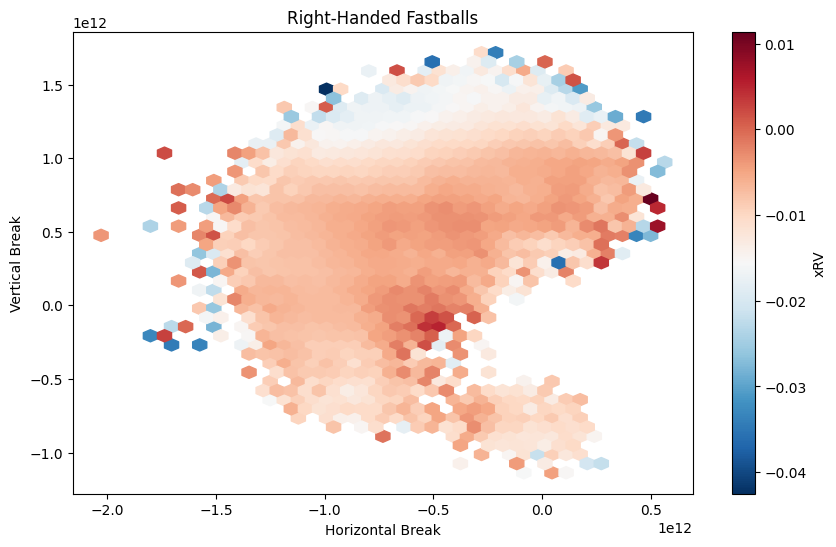

In [272]:
import matplotlib.pyplot as plt

fastball_r_df = fastball_df[fastball_df['p_throws'] == 'R']

plt.figure(figsize=(10, 6))
plt.hexbin(fastball_r_df['pfx_x'], fastball_r_df['pfx_z'], C=fastball_r_df['xRV'], gridsize=40,cmap='RdBu_r')

# Set labels and title
plt.xlabel('Horizontal Break')
plt.ylabel('Vertical Break')
plt.title('Right-Handed Fastballs')

# Show the colorbar
plt.colorbar(label='xRV')

# Show the plot
plt.show()

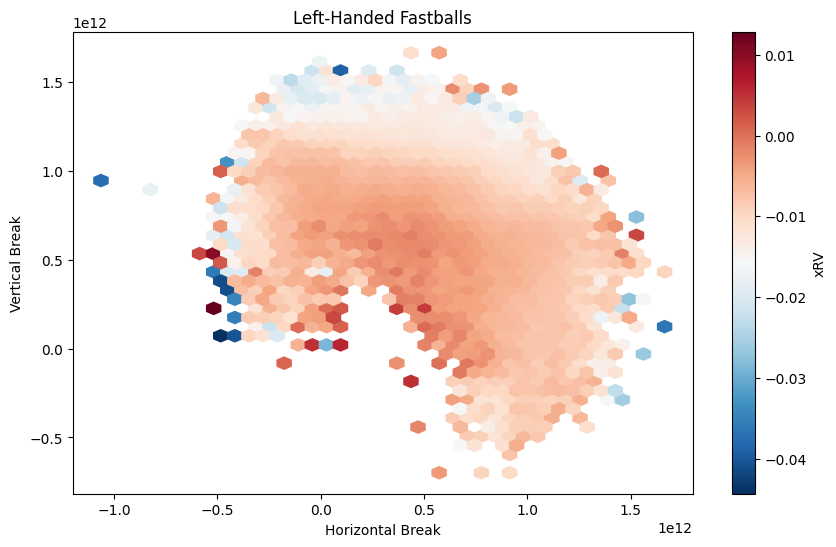

In [273]:
fastball_l_df = fastball_df[fastball_df['p_throws'] == 'L']

plt.figure(figsize=(10, 6))
plt.hexbin(fastball_l_df['pfx_x'], fastball_l_df['pfx_z'], C=fastball_l_df['xRV'], gridsize=40,cmap='RdBu_r')

# Set labels and title
plt.xlabel('Horizontal Break')
plt.ylabel('Vertical Break')
plt.title('Left-Handed Fastballs')

# Show the colorbar
plt.colorbar(label='xRV')

# Show the plot
plt.show()

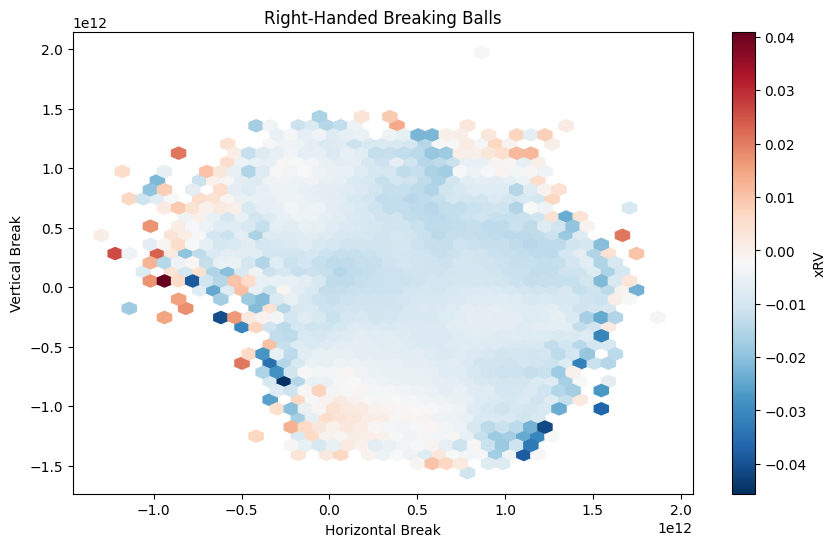

In [274]:
bb_r_df = bb_df[bb_df['p_throws'] == 'R']

plt.figure(figsize=(10, 6))
plt.hexbin(bb_r_df['pfx_x'], bb_r_df['pfx_z'], C=bb_r_df['xRV'], gridsize=40,cmap='RdBu_r')

# Set labels and title
plt.xlabel('Horizontal Break')
plt.ylabel('Vertical Break')
plt.title('Right-Handed Breaking Balls')

# Show the colorbar
plt.colorbar(label='xRV')

# Show the plot
plt.show()

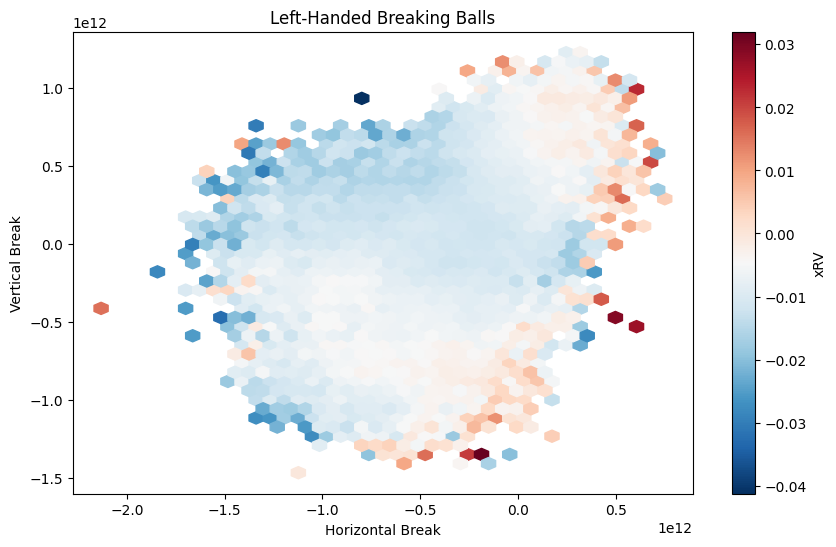

In [275]:
bb_l_df = bb_df[bb_df['p_throws'] == 'L']

plt.figure(figsize=(10, 6))
plt.hexbin(bb_l_df['pfx_x'], bb_l_df['pfx_z'], C=bb_l_df['xRV'], gridsize=40,cmap='RdBu_r')

# Set labels and title
plt.xlabel('Horizontal Break')
plt.ylabel('Vertical Break')
plt.title('Left-Handed Breaking Balls')

# Show the colorbar
plt.colorbar(label='xRV')

# Show the plot
plt.show()

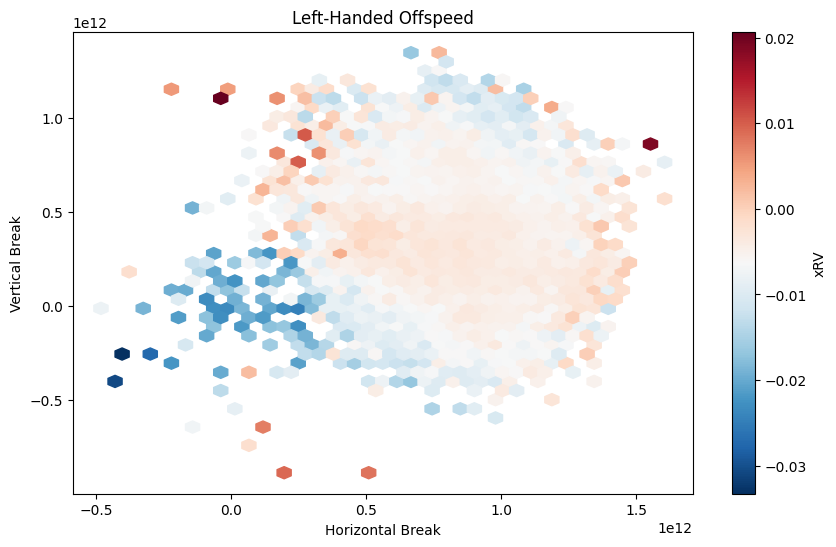

In [276]:
offs_l_df = offs_df[offs_df['p_throws'] == 'L']

plt.figure(figsize=(10, 6))
plt.hexbin(offs_l_df['pfx_x'], offs_l_df['pfx_z'], C=offs_l_df['xRV'], gridsize=40,cmap='RdBu_r')

# Set labels and title
plt.xlabel('Horizontal Break')
plt.ylabel('Vertical Break')
plt.title('Left-Handed Offspeed')

# Show the colorbar
plt.colorbar(label='xRV')

# Show the plot
plt.show()

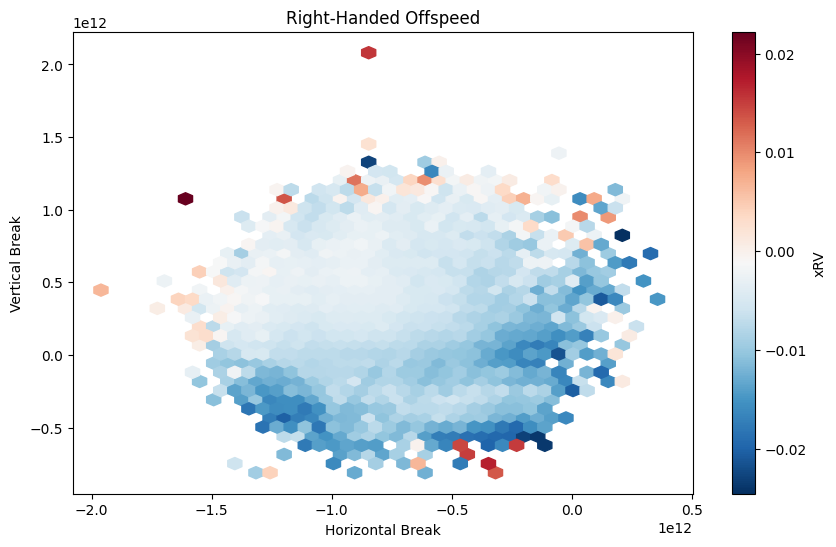

In [277]:
offs_r_df = offs_df[offs_df['p_throws'] == 'R']

plt.figure(figsize=(10, 6))
plt.hexbin(offs_r_df['pfx_x'], offs_r_df['pfx_z'], C=offs_r_df['xRV'], gridsize=40,cmap='RdBu_r')

# Set labels and title
plt.xlabel('Horizontal Break')
plt.ylabel('Vertical Break')
plt.title('Right-Handed Offspeed')

# Show the colorbar
plt.colorbar(label='xRV')

# Show the plot
plt.show()